In [24]:
import pandas as pd
import numpy as np


from pathlib import Path
import sys
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))
from libs.functions import *

In [25]:
df = pd.read_csv('data/predictions.csv')
df.rename(columns={'Unnamed: 0': 'index_original'}, inplace=True)
df

,index_original,period,timestamp,ticker,y_true,discount,Naïve,OLS,LASSO,MLP,MLP-Pyr,discount_month,y_true_full,Naïve_full,OLS_full,LASSO_full,MLP_full,MLP-Pyr_full
0,228,21,2021-01-31,AAB.CO,0.004785,0.0000,0.008812,0.014568,0.026861,0.022544,0.016144,0.000000,0.004785,0.008812,0.014568,0.026861,0.022544,0.016144
1,229,21,2021-02-28,AAB.CO,-0.028571,0.0000,0.008812,0.022468,0.028238,0.021499,0.016413,0.000000,-0.028571,0.008812,0.022468,0.028238,0.021499,0.016413
2,230,21,2021-03-31,AAB.CO,-0.009804,0.0000,0.008812,0.041455,0.025399,0.020335,0.017362,0.000000,-0.009804,0.008812,0.041455,0.025399,0.020335,0.017362
3,231,21,2021-04-30,AAB.CO,0.084158,0.0000,0.008812,0.032088,0.024087,0.016490,0.010342,0.000000,0.084158,0.008812,0.032088,0.024087,0.016490,0.010342
4,232,21,2021-05-31,AAB.CO,-0.068493,0.0000,0.008812,0.028618,0.021055,0.015101,0.007152,0.000000,-0.068493,0.008812,0.028618,0.021055,0.015101,0.007152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,45570,24,2024-08-31,ZELA.CO,-0.085660,0.0335,0.008954,0.012422,0.046373,0.012966,0.013060,0.002750,-0.082910,0.011704,0.015172,0.049123,0.015715,0.015810
5955,45571,24,2024-09-30,ZELA.CO,-0.030425,0.0310,0.008954,-0.051152,0.038206,0.013133,0.010812,0.002547,-0.027878,0.011502,-0.048605,0.040753,0.015681,0.013360
5956,45572,24,2024-10-31,ZELA.CO,-0.079081,0.0285,0.008954,-0.050271,0.039111,0.014784,0.009792,0.002344,-0.076737,0.011299,-0.047927,0.041455,0.017128,0.012136
5957,45573,24,2024-11-30,ZELA.CO,-0.022208,0.0285,0.008954,-0.001312,0.031701,0.011581,0.005026,0.002344,-0.019863,0.011299,0.001032,0.034046,0.013926,0.007370


In [26]:
df['decile_ols'] = df.groupby(['timestamp'])['OLS'].transform(deciles)
df['decile_mlp'] = df.groupby(['timestamp'])['MLP'].transform(deciles)
df['decile_lasso'] = df.groupby(['timestamp'])['LASSO'].transform(deciles)
df['decile_mlp-pyr'] = df.groupby(['timestamp'])['MLP-Pyr'].transform(deciles)

display(df.sort_values(by=['timestamp', 'decile_mlp']))

,index_original,period,timestamp,ticker,y_true,discount,Naïve,OLS,LASSO,MLP,...,y_true_full,Naïve_full,OLS_full,LASSO_full,MLP_full,MLP-Pyr_full,decile_ols,decile_mlp,decile_lasso,decile_mlp-pyr
337,3586,21,2021-01-31,ATLA.CO,0.025000,0.000,0.008812,-0.068114,-0.006517,0.001764,...,0.025000,0.008812,-0.068114,-0.006517,0.001764,-0.019761,0,0,0,0
385,4033,21,2021-01-31,BAVA.CO,0.005460,0.000,0.008812,0.020622,0.005974,-0.011943,...,0.005460,0.008812,0.020622,0.005974,-0.011943,0.004187,3,0,0,0
435,4443,21,2021-01-31,BIF.CO,0.169725,0.000,0.008812,0.004029,0.021358,0.006724,...,0.169725,0.008812,0.004029,0.021358,0.006724,0.011793,1,0,4,1
961,8208,21,2021-01-31,CPHCAPST.CO,0.055556,0.000,0.008812,0.032147,0.011804,0.007167,...,0.055556,0.008812,0.032147,0.011804,0.007167,0.010871,4,0,0,0
1345,11279,21,2021-01-31,DRLCO.CO^J22,0.448763,0.000,0.008812,-0.075623,0.004320,0.012352,...,0.448763,0.008812,-0.075623,0.004320,0.012352,0.009775,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5066,37957,24,2024-12-31,SKAKO.CO,0.027212,0.026,0.008954,0.014789,0.033003,0.019751,...,0.029353,0.011095,0.016930,0.035145,0.021892,0.024750,4,9,9,9
5210,39382,24,2024-12-31,SPGP.CO,-0.010475,0.026,0.008954,0.058702,0.022162,0.013987,...,-0.008333,0.011095,0.060843,0.024303,0.016129,0.014227,9,9,7,8
5402,40203,24,2024-12-31,STRAP.CO,0.027712,0.026,0.008954,0.057187,0.024605,0.019532,...,0.029854,0.011095,0.059328,0.026746,0.021673,0.018824,9,9,8,9
5546,40940,24,2024-12-31,TCM.CO,0.042432,0.026,0.008954,0.024207,0.030837,0.015114,...,0.044573,0.011095,0.026348,0.032978,0.017255,0.018013,5,9,9,9


In [27]:
# models & their decile‐column suffixes:
models = {
    'ols':      'decile_ols',
    'mlp':      'decile_mlp',
    'lasso':    'decile_lasso',
    'mlp_pyr':  'decile_mlp-pyr'
}

perf_dfs = []

for name, dec_col in models.items():
    tmp = df.copy()
    
    # 1) positions: +1 for top decile (9), -1 for bottom (0)
    tmp['position'] = 0
    tmp.loc[tmp[dec_col] == 9, 'position'] =  1
    tmp.loc[tmp[dec_col] == 0, 'position'] = -1
    
    # 2) count longs/shorts per timestamp
    tmp['n_long']  = tmp.groupby('timestamp')['position'].transform(lambda x: (x==1).sum())
    tmp['n_short'] = tmp.groupby('timestamp')['position'].transform(lambda x: (x==-1).sum())
    
    # 3) equal‐weight each leg
    tmp['weight'] = 0.0
    long_mask  = tmp['position'] ==  1
    short_mask = tmp['position'] == -1
    tmp.loc[ long_mask, 'weight'] =  1.0 / tmp.loc[ long_mask, 'n_long']
    tmp.loc[short_mask, 'weight'] = -1.0 / tmp.loc[short_mask, 'n_short']
    
    # 4) realized strategy return
    tmp['strat_ret'] = tmp['y_true'] * tmp['weight']
    
    # 5) aggregate to timestamp
    perf = (
        tmp
        .groupby('timestamp')['strat_ret']
        .sum()
        .reset_index(name=name)
    )
    perf_dfs.append(perf)

# 6) Merge all model‐returns on timestamp
from functools import reduce

strategy_all = reduce(lambda left, right: pd.merge(left, right, on='timestamp'), perf_dfs)

# compute cumulative returns for each model
for name in ['ols', 'mlp', 'lasso', 'mlp_pyr']:
    # calculate the compounded (wealth‐index) series, starting from 1.0
    strategy_all[f'cum_{name}'] = (1 + strategy_all[name]).cumprod()

display(strategy_all.head())

,timestamp,ols,mlp,lasso,mlp_pyr,cum_ols,cum_mlp,cum_lasso,cum_mlp_pyr
0,2021-01-31,-0.037846,-0.013355,-0.102657,-0.017159,0.962154,0.986645,0.897343,0.982841
1,2021-02-28,-0.057270,-0.078569,-0.060495,-0.016436,0.907051,0.909125,0.843058,0.966687
2,2021-03-31,0.067654,0.157820,0.152041,0.206494,0.968417,1.052603,0.971237,1.166302
3,2021-04-30,-0.084106,-0.024132,0.002912,-0.034827,0.886967,1.027201,0.974065,1.125683
4,2021-05-31,0.044434,0.045363,0.036962,0.032095,0.926378,1.073798,1.010069,1.161812


In [28]:
# 1) Make sure timestamp is datetime
strategy_all['timestamp'] = pd.to_datetime(strategy_all['timestamp'])

# 2) Define your models / return‐columns
ret_cols = ['ols', 'mlp', 'lasso', 'mlp_pyr']

# 3) Build the “initial” row with zero returns
initial = pd.DataFrame({
    'timestamp': [pd.to_datetime('2020-12-31')],
    **{col: 0.0 for col in ret_cols}
})

# 4) Concatenate and sort
full = pd.concat([initial, strategy_all[['timestamp'] + ret_cols]],
                 ignore_index=True)
full = full.sort_values('timestamp').reset_index(drop=True)

# 5) Compute compounded wealth (starting from 1 on 2020-12-31)
for col in ret_cols:
    full[f'cum_{col}'] = (1 + full[col]).cumprod()

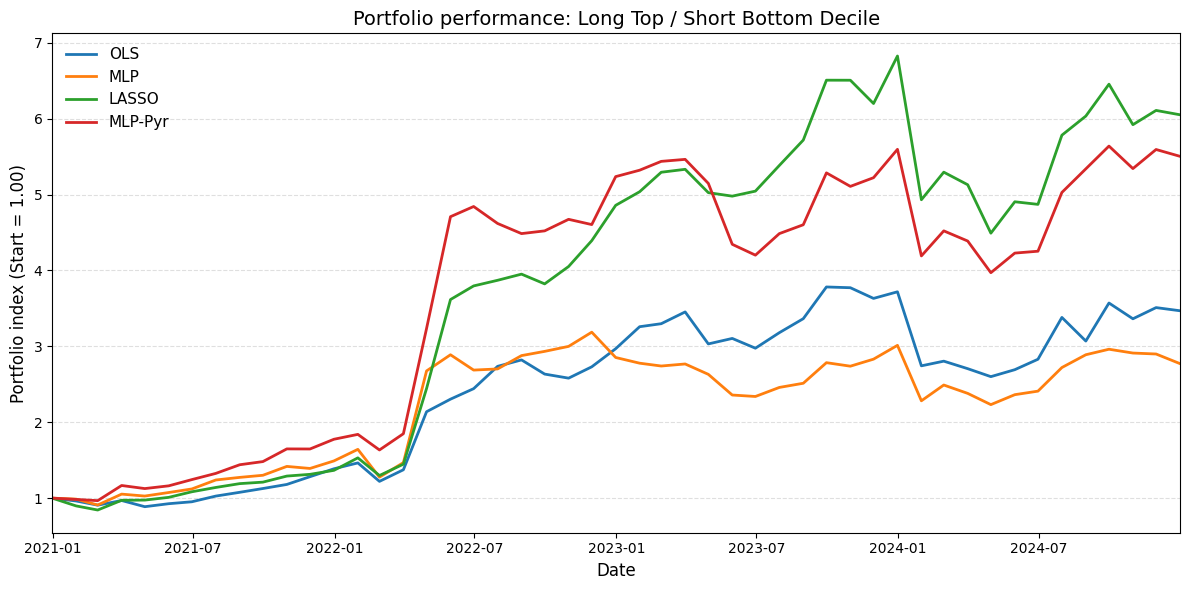

In [30]:
import matplotlib.pyplot as plt

# List of the cumulative-return columns and display names:
cum_cols = ['cum_ols', 'cum_mlp', 'cum_lasso', 'cum_mlp_pyr']
labels   = ['OLS', 'MLP', 'LASSO', 'MLP-Pyr']

plt.figure(figsize=(12, 6))
for col, label in zip(cum_cols, labels):
    plt.plot(full['timestamp'], full[col], label=label, linewidth=2)

# Styling
plt.xlim(full['timestamp'].min(), full['timestamp'].max())
plt.title('Portfolio performance: Long Top / Short Bottom Decile', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio index (Start = 1.00)', fontsize=12)
plt.legend(frameon=False, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Tight layout for nicer spacing
plt.tight_layout()
plt.show()
